In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv


In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")



data = pd.read_csv('/kaggle/input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv')


print(data.head())


print(data['sentiment'].value_counts())


                                              review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive
sentiment
positive    25000
negative    25000
Name: count, dtype: int64


Keşifsel Veri Analizi (Exploratory Data Analysis - EDA)

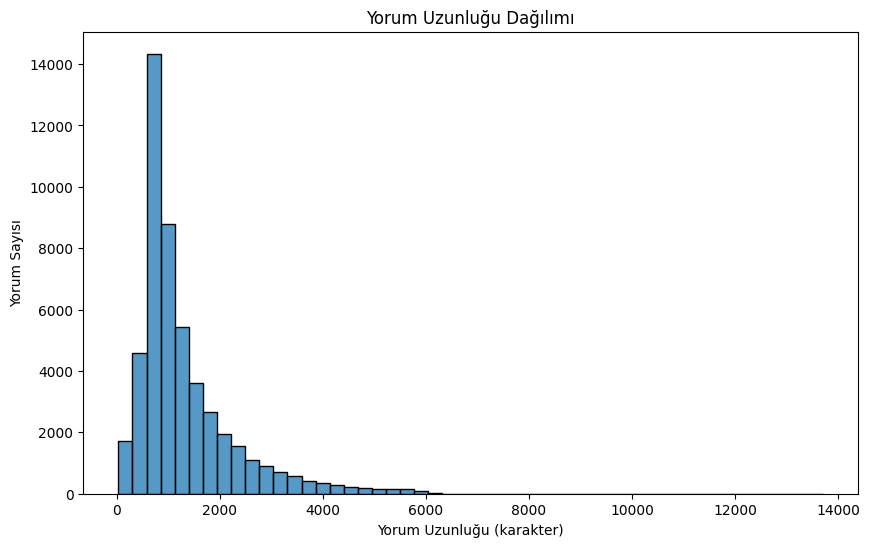

In [6]:

data['review_length'] = data['review'].apply(len)


plt.figure(figsize=(10,6))
sns.histplot(data['review_length'], bins=50)
plt.title('Yorum Uzunluğu Dağılımı')
plt.xlabel('Yorum Uzunluğu (karakter)')
plt.ylabel('Yorum Sayısı')
plt.show()


Pozitif ve Negatif Yorumların Dağılımı

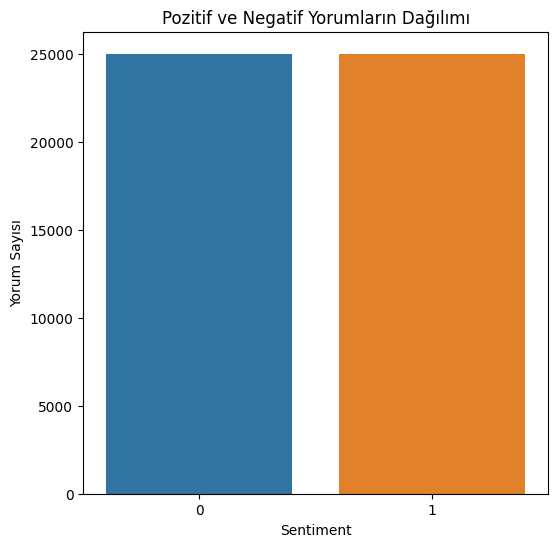

In [10]:

plt.figure(figsize=(6,6))
sns.countplot(x='sentiment', data=data)
plt.title('Pozitif ve Negatif Yorumların Dağılımı')
plt.xlabel('Sentiment')
plt.ylabel('Yorum Sayısı')
plt.show()


Veri Ön İşleme

In [11]:
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer

# Sentiment etiketlerini sayısal değerlere dönüştürelim
label_encoder = LabelEncoder()
data['sentiment'] = label_encoder.fit_transform(data['sentiment'])  # 0: negative, 1: positive

# TF-IDF ile metin verisini sayısallaştıralım
tfidf_vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
X = tfidf_vectorizer.fit_transform(data['review'])

# Hedef değişkenimiz: sentiment (pozitif/negatif sınıflar)
y = data['sentiment']
y

0        1
1        1
2        1
3        0
4        1
        ..
49995    1
49996    0
49997    0
49998    0
49999    0
Name: sentiment, Length: 50000, dtype: int64

Train-test ayırma

In [12]:
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Eğitim ve test seti boyutlarını kontrol edelim
print(f"Eğitim seti boyutu: {X_train.shape}")
print(f"Test seti boyutu: {X_test.shape}")


Eğitim seti boyutu: (40000, 5000)
Test seti boyutu: (10000, 5000)


Denetimli Öğrenme


In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)


y_pred = log_reg.predict(X_test)


print(f"Doğruluk Oranı: {accuracy_score(y_test, y_pred)}")
print(classification_report(y_test, y_pred))


conf_matrix = confusion_matrix(y_test, y_pred)
print(conf_matrix)


Doğruluk Oranı: 0.8898
              precision    recall  f1-score   support

           0       0.90      0.87      0.89      4961
           1       0.88      0.91      0.89      5039

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000

[[4333  628]
 [ 474 4565]]


Logistic regreesion hiperparametre optimizasyonu

In [15]:
from sklearn.model_selection import GridSearchCV


param_grid = {'C': [0.01, 0.1, 1, 10], 'penalty': ['l1', 'l2'], 'solver': ['liblinear']}


grid_search = GridSearchCV(LogisticRegression(max_iter=100), param_grid, cv=5)
grid_search.fit(X_train, y_train)


print(f"En iyi parametreler: {grid_search.best_params_}")
best_log_reg = grid_search.best_estimator_
y_pred_best = best_log_reg.predict(X_test)


print(f"Optimizasyon Sonrası Doğruluk Oranı: {accuracy_score(y_test, y_pred_best)}")


En iyi parametreler: {'C': 1, 'penalty': 'l2', 'solver': 'liblinear'}
Optimizasyon Sonrası Doğruluk Oranı: 0.8898


Denetimsiz Öğrenme

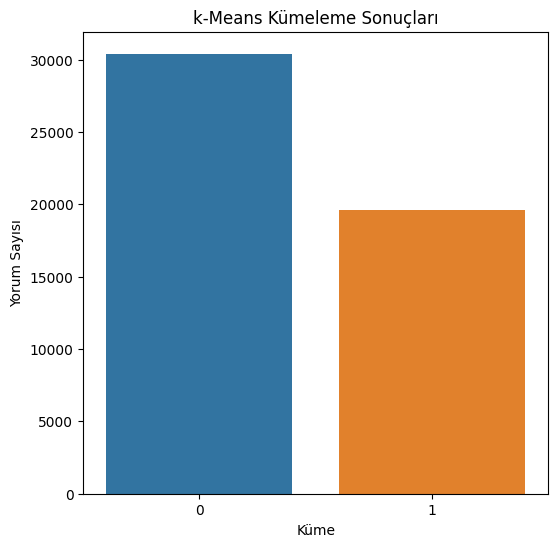

col_0          0      1
sentiment              
0          14748  10252
1          15664   9336


In [14]:
from sklearn.cluster import KMeans
import numpy as np


kmeans = KMeans(n_clusters=2, random_state=42)
clusters = kmeans.fit_predict(X)

plt.figure(figsize=(6,6))
sns.countplot(x=clusters)
plt.title('k-Means Kümeleme Sonuçları')
plt.xlabel('Küme')
plt.ylabel('Yorum Sayısı')
plt.show()

# Gerçek sınıflarla kümeleri karşılaştıralım
cross_tab = pd.crosstab(data['sentiment'], clusters)
print(cross_tab)
